## Importing libraries

In [184]:
import pandas as pd
from pathlib import Path
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import root_mean_squared_error, r2_score
# from sklearn.experimental import enable_iterative_imputer  # noqa
# from sklearn.impute import IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBRegressor
import joblib

import warnings
warnings.filterwarnings("ignore")

## Load the Data

[source](https://colab.research.google.com/github/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb#scrollTo=2lv90rC0Up2d)

Rather than manually downloading and decompressing the data, it's usually preferable to write a function that does it for you.
This is useful if the data changes regularly or if it's needed to install the dataset on multiple machines.

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## drop duplicates

In [4]:
housing.duplicated().sum()

0

## Split the data

Suppose that we know that the `median_income` feature is very important for predicting housing prices, so we want to create a categorical column using this "income" numeric column. From the histogram, most values fall between 1.5 and 6, but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum's importance may be biased. This means that we
should not have too many strata, and each stratum should be large enough.

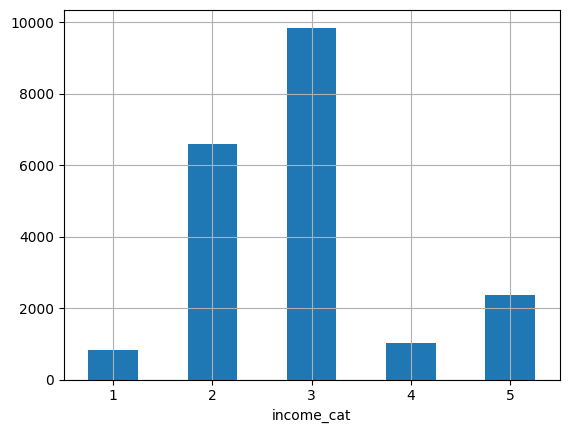

In [5]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0, 1.5, 3, 5.4, 6, np.inf], labels=[1,2,3,4,5])
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.show()

In [6]:
train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

## Data overview

In [7]:
train_set.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
16197,-117.16,34.08,9.0,5306.0,993.0,2630.0,925.0,4.5100,135800.0,INLAND,3
7337,-118.16,34.17,46.0,1508.0,261.0,674.0,255.0,3.5909,155400.0,<1H OCEAN,3
15539,-120.43,34.93,10.0,2980.0,585.0,1593.0,562.0,3.2850,218300.0,<1H OCEAN,3
6409,-118.79,34.26,17.0,1986.0,249.0,761.0,241.0,7.2137,401900.0,<1H OCEAN,5
797,-118.28,34.16,49.0,1393.0,290.0,605.0,282.0,2.9491,257400.0,<1H OCEAN,2


In [8]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13025 to 19940
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16512 non-null  float64 
 1   latitude            16512 non-null  float64 
 2   housing_median_age  16512 non-null  float64 
 3   total_rooms         16512 non-null  float64 
 4   total_bedrooms      16343 non-null  float64 
 5   population          16512 non-null  float64 
 6   households          16512 non-null  float64 
 7   median_income       16512 non-null  float64 
 8   median_house_value  16512 non-null  float64 
 9   ocean_proximity     16512 non-null  object  
 10  income_cat          16512 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.4+ MB


`total_bedrooms` has some Nans

In [9]:
train_set['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     7287
INLAND        5248
NEAR OCEAN    2124
NEAR BAY      1851
ISLAND           2
Name: count, dtype: int64

In [10]:
train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16343.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.572281,35.633282,28.716146,2618.501272,535.488894,1415.599806,496.880511,3.870792,207072.897287
std,2.002477,2.133716,12.595751,2144.139489,418.399145,1079.768089,377.978564,1.903882,116068.081591
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1441.000000,295.000000,783.000000,278.000000,2.562500,119200.000000
50%,-118.500000,34.260000,29.000000,2115.000000,432.000000,1162.000000,407.000000,3.534100,179500.000000
75%,-118.010000,37.720000,37.000000,3128.000000,644.000000,1715.000000,601.250000,4.734700,265300.000000
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,500001.000000


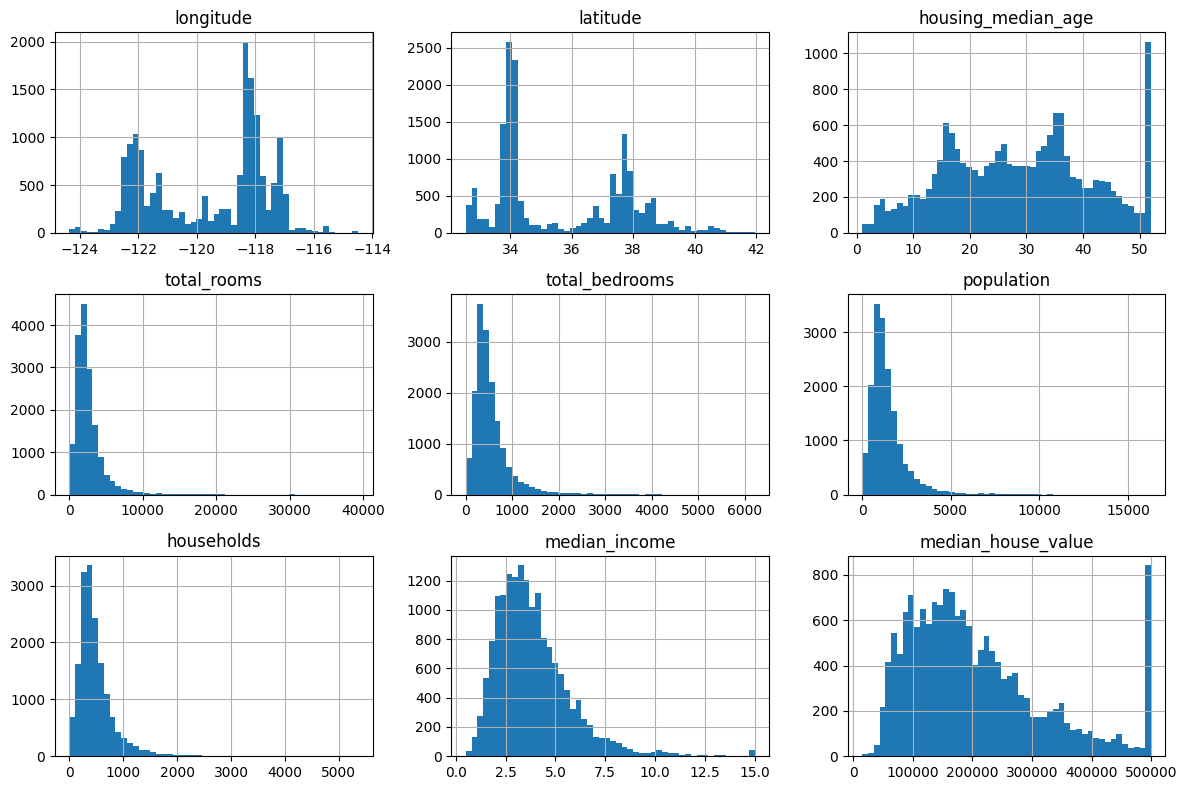

In [11]:
train_set.hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

- It's clear that there are some capped columns. I will remove capped data from  the `mdeian_house_value` column only because it's the target variable. (remove capped values to misleading results)

- some columns have skewed distributions (later, we apply log transformation)

- columns have very different scales (later, we scale them to the same range)

In [12]:
train_set.drop(train_set.loc[train_set['median_house_value'] == train_set['median_house_value'].max()].index, inplace=True)
test_set.drop(test_set.loc[test_set['median_house_value'] == test_set['median_house_value'].max()].index, inplace=True)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15728 entries, 13025 to 19940
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           15728 non-null  float64 
 1   latitude            15728 non-null  float64 
 2   housing_median_age  15728 non-null  float64 
 3   total_rooms         15728 non-null  float64 
 4   total_bedrooms      15566 non-null  float64 
 5   population          15728 non-null  float64 
 6   households          15728 non-null  float64 
 7   median_income       15728 non-null  float64 
 8   median_house_value  15728 non-null  float64 
 9   ocean_proximity     15728 non-null  object  
 10  income_cat          15728 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.3+ MB


## Visualization

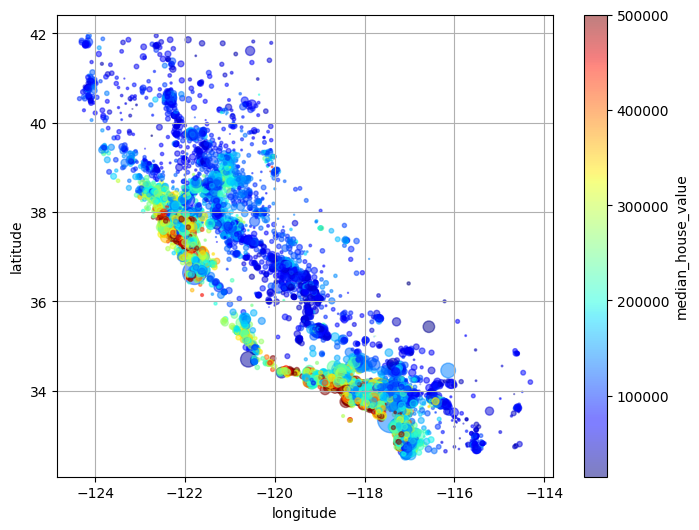

In [13]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True,
             s=housing['population'] / 100, c='median_house_value',
             colorbar=True, cmap='jet', figsize=(8, 6), alpha=0.5)
plt.show()

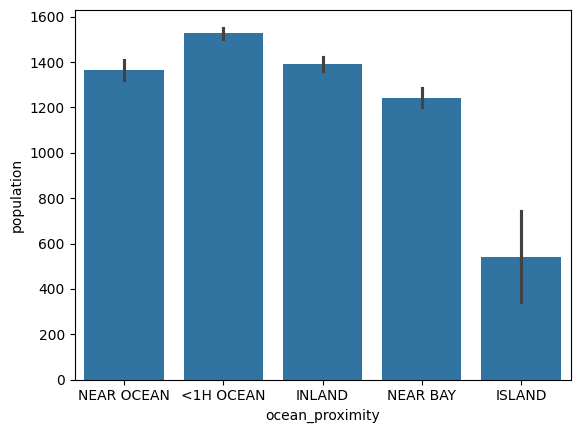

In [14]:
sns.barplot(data=train_set, x='ocean_proximity', y='population')
plt.show()

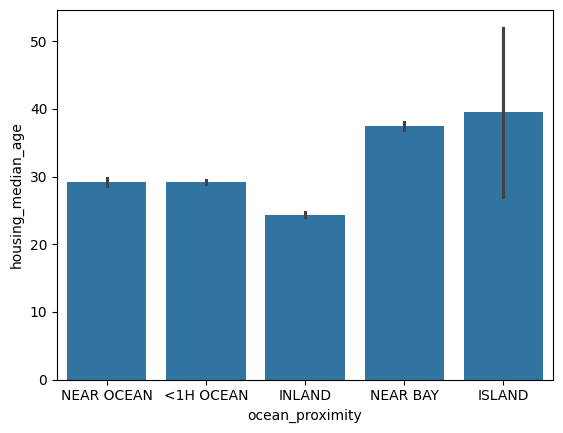

In [15]:
sns.barplot(data=train_set, x='ocean_proximity', y='housing_median_age')
plt.show()

## Investigate correlations

In [16]:
train_set.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.639832
total_rooms           0.144678
households            0.095853
total_bedrooms        0.075206
housing_median_age    0.068251
population            0.012716
longitude            -0.053867
latitude             -0.141448
Name: median_house_value, dtype: float64

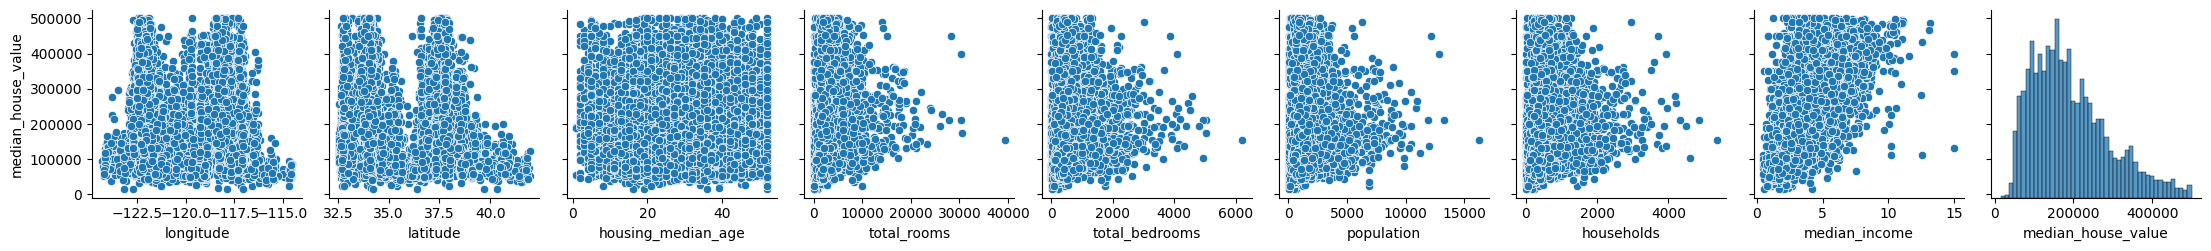

In [17]:
sns.pairplot(train_set, y_vars='median_house_value')
plt.show()

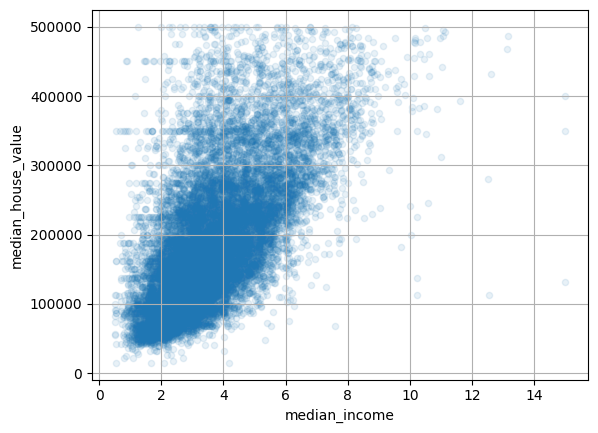

In [18]:
train_set.plot(kind='scatter', x='median_income', y='median_house_value',
             alpha=0.1, grid=True)
plt.show()

## Imputation

In [19]:
train_set.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        162
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
income_cat              0
dtype: int64

In [20]:
train_set['total_bedrooms'].fillna(train_set['total_bedrooms'].median(), inplace=True)
train_set.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
income_cat            0
dtype: int64

# Feature engineering

## Attribute combinations

In [21]:
train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [22]:
train_set['rooms_per_house'] = train_set['total_rooms'] / train_set['households']
train_set['bedrooms_ratio'] = train_set['total_bedrooms'] / train_set['total_rooms']
train_set['people_per_house'] = train_set['population'] / train_set['households']

In [23]:
kmeans = KMeans(n_clusters=10).fit(train_set[['longitude', 'latitude']])
kmeans.cluster_centers_

array([[-116.92402668,   33.03896907],
       [-122.11960719,   37.568998  ],
       [-118.07505169,   33.99958494],
       [-118.88196023,   35.53872159],
       [-122.56591631,   38.45007215],
       [-121.27365874,   38.92771647],
       [-123.0199361 ,   40.68939297],
       [-119.8890239 ,   34.64870518],
       [-119.67216327,   36.65854422],
       [-121.00704019,   37.74805116]])

In [24]:
for col in range(kmeans.n_clusters):
    cluster_center = kmeans.cluster_centers_[col].reshape(1, -1)
    train_set[f'location{col+1} similarity'] = rbf_kernel(train_set[['longitude', 'latitude']], cluster_center)

In [25]:
train_set.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

median_house_value       1.000000
median_income            0.639832
location2 similarity     0.206644
location3 similarity     0.172174
total_rooms              0.144678
location5 similarity     0.125729
rooms_per_house          0.104905
location8 similarity     0.096404
households               0.095853
total_bedrooms           0.074796
housing_median_age       0.068251
location1 similarity     0.016376
population               0.012716
people_per_house        -0.020225
location10 similarity   -0.040833
longitude               -0.053867
location4 similarity    -0.084187
location6 similarity    -0.138846
latitude                -0.141448
bedrooms_ratio          -0.191035
location7 similarity    -0.195481
location9 similarity    -0.296614
Name: median_house_value, dtype: float64

## Handling abnormal distributions (skewed & multi-modal)

One approach to transforming multimodal distributions is to add a feature for each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode

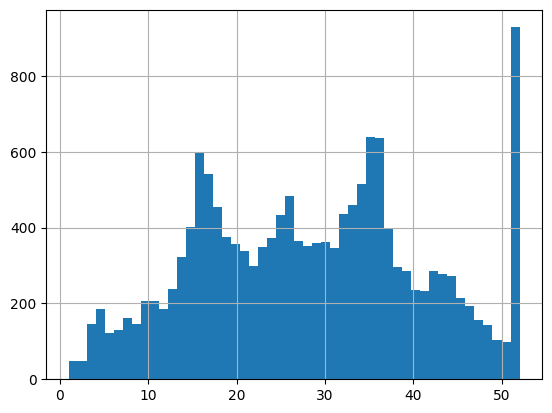

In [26]:
train_set['housing_median_age'].hist(bins=50)
plt.show()

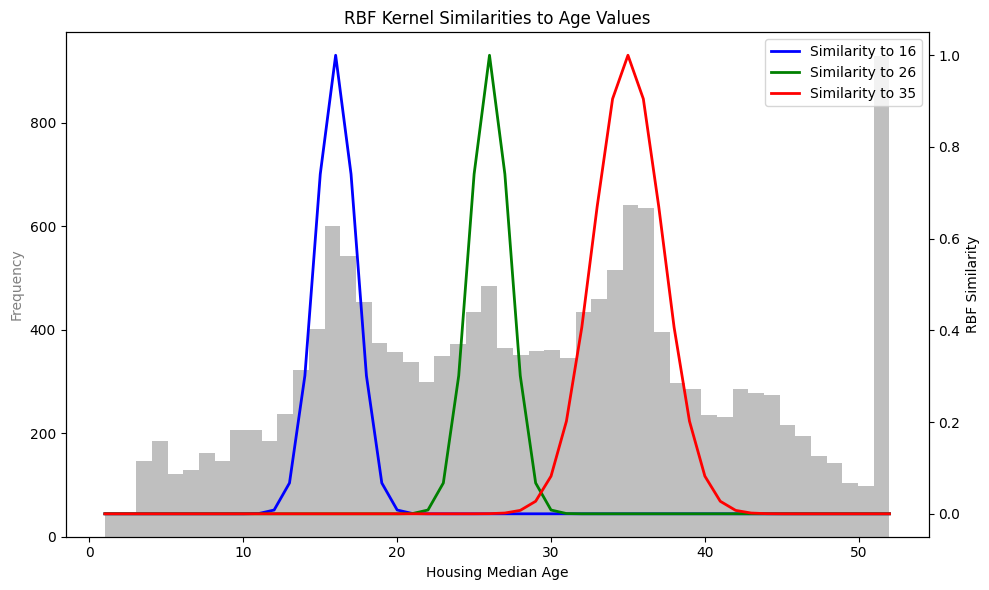

In [27]:
# Group by 'housing_median_age' to get one unique value per x for plotting
unique_ages = np.sort(train_set['housing_median_age'].unique()).reshape(-1, 1)

age_simil_16 = rbf_kernel(unique_ages, [[16]], gamma=0.3)
age_simil_26 = rbf_kernel(unique_ages, [[26]], gamma=0.3)
age_simil_35 = rbf_kernel(unique_ages, [[35]], gamma=0.1)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(train_set['housing_median_age'], bins=50, color='gray', alpha=0.5)
ax1.set_xlabel("Housing Median Age")
ax1.set_ylabel("Frequency", color='gray')

# Second y-axis for RBF similarities
ax2 = ax1.twinx()
ax2.plot(unique_ages, age_simil_16, label='Similarity to 16', color='blue', linewidth=2)
ax2.plot(unique_ages, age_simil_26, label='Similarity to 26', color='green', linewidth=2)
ax2.plot(unique_ages, age_simil_35, label='Similarity to 35', color='red', linewidth=2)
ax2.set_ylabel("RBF Similarity", color='black')

plt.title("RBF Kernel Similarities to Age Values")
ax2.legend()
plt.tight_layout()
plt.show()


In [28]:
age_simil_16 = rbf_kernel(train_set[['housing_median_age']], [[16]], gamma=0.3)
age_simil_26 = rbf_kernel(train_set[['housing_median_age']], [[26]], gamma=0.3)
age_simil_35 = rbf_kernel(train_set[['housing_median_age']], [[35]], gamma=0.1)

In [29]:
train_set['age_simil_16'] = age_simil_16
train_set['age_simil_26'] = age_simil_26
train_set['age_simil_35'] = age_simil_35

## log transformation

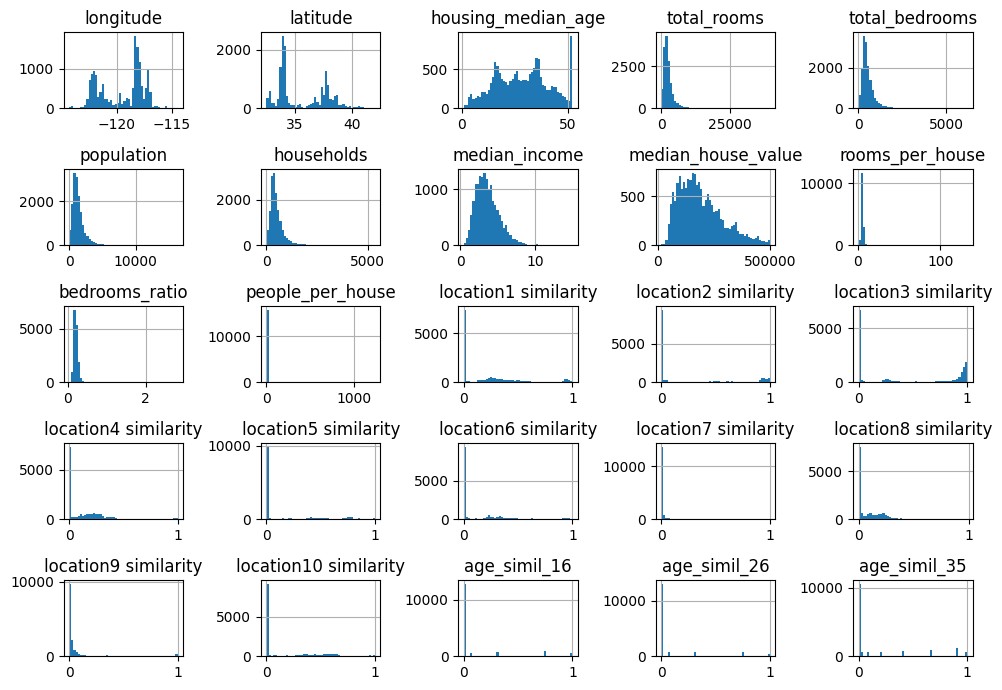

In [30]:
train_set.hist(bins=50, figsize=(10, 7))
plt.tight_layout()
plt.show()

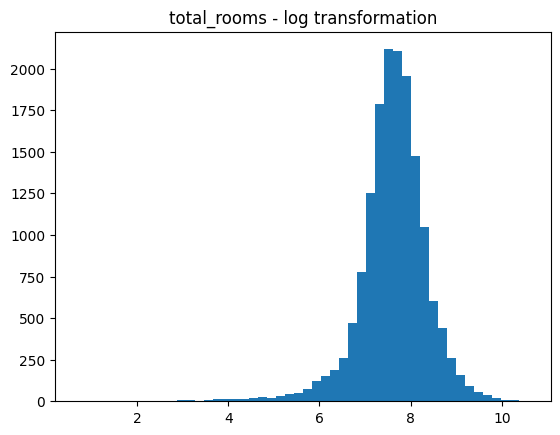

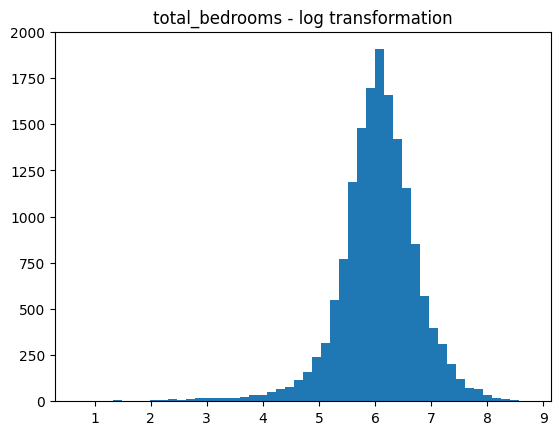

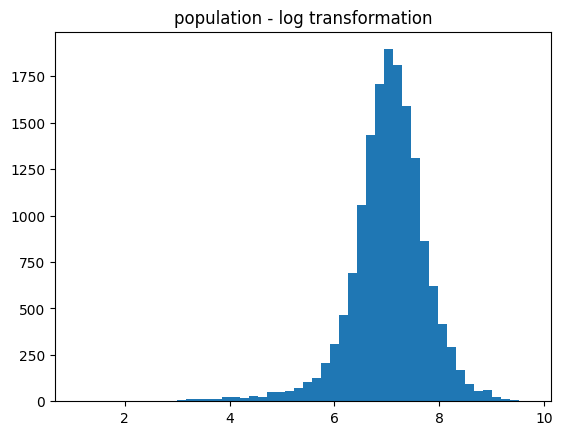

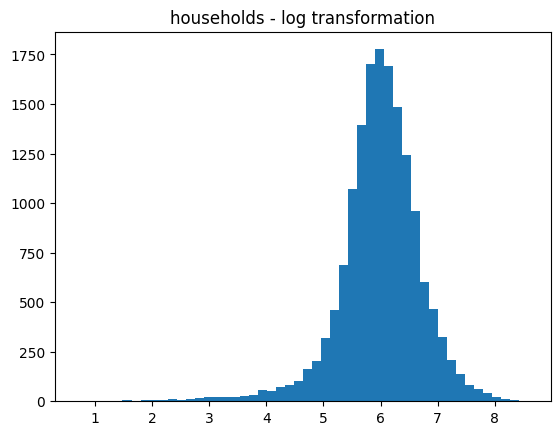

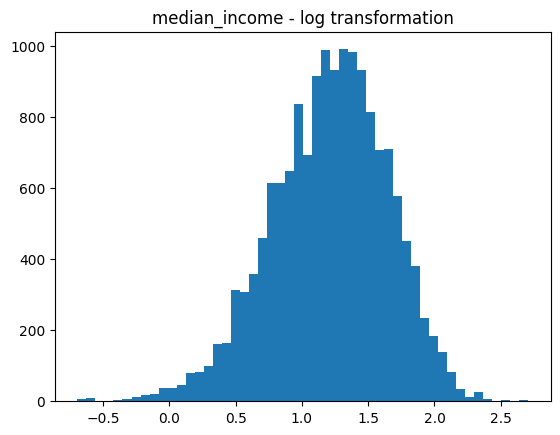

In [31]:
log_cols = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
for col in log_cols:
  plt.hist(np.log(train_set[col]), bins=50)
  plt.title(f'{col} - log transformation')
  plt.show()

In [32]:
for col in log_cols:
    train_set[f'log_{col}'] = np.log(train_set[col])

## Scaling

In [33]:
X_train = train_set.drop(columns=['median_house_value'])
y_train = train_set['median_house_value']

In [34]:
num_cols = X_train.select_dtypes(include=np.number).columns
cat_cols = X_train.select_dtypes(include='object').columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])

### One-hot encoding

In [35]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[cat_cols])

In [36]:
X_train_scaled_encoded = pd.DataFrame(np.c_[X_train_scaled, X_train_encoded], columns=list(num_cols) + list(encoder.get_feature_names_out()))
X_train_scaled_encoded.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,...,age_simil_35,log_total_rooms,log_total_bedrooms,log_population,log_households,log_median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.711432,-0.886701,0.841213,-0.284494,0.233337,-0.518830,0.179647,0.258194,-0.772456,1.552943,...,0.083766,-0.026049,0.550686,-0.363495,0.491720,0.447039,0.0,0.0,0.0,1.0
1,1.090499,-0.923956,-1.554695,4.984319,5.254926,5.328097,4.889765,-0.190158,0.121352,-0.163981,...,-0.542160,2.508046,2.563371,2.524221,2.437780,0.017296,0.0,0.0,0.0,0.0
2,-1.183904,1.260144,-2.113740,1.095578,0.475544,0.329562,0.166438,0.866030,1.443139,-1.032438,...,-0.542160,1.189201,0.754567,0.623951,0.479597,0.923889,1.0,0.0,0.0,0.0
3,-0.859702,1.367253,-0.756059,-0.067546,-0.159949,-0.079025,-0.050180,-0.011135,-0.100209,-0.381329,...,-0.542160,0.253949,0.137858,0.235178,0.263728,0.198770,1.0,0.0,0.0,0.0
4,-1.378426,1.069210,1.400259,-0.495377,-0.474098,-0.601466,-0.467565,0.266595,-0.239587,0.055851,...,-0.542143,-0.369389,-0.312783,-0.512667,-0.282711,0.454362,0.0,0.0,1.0,0.0


In [39]:
train_set.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

median_house_value       1.000000
median_income            0.639832
log_median_income        0.611024
location2 similarity     0.206644
log_total_rooms          0.174001
location3 similarity     0.172174
total_rooms              0.144678
location5 similarity     0.125729
log_households           0.113303
rooms_per_house          0.104905
location8 similarity     0.096404
households               0.095853
log_total_bedrooms       0.089117
total_bedrooms           0.074796
housing_median_age       0.068251
log_population           0.024429
age_simil_26             0.021844
location1 similarity     0.016376
population               0.012716
age_simil_35            -0.003444
people_per_house        -0.020225
age_simil_16            -0.024844
location10 similarity   -0.040833
longitude               -0.053867
location4 similarity    -0.084187
location6 similarity    -0.138846
latitude                -0.141448
bedrooms_ratio          -0.191035
location7 similarity    -0.195481
location9 simi

## build the whole pipeline

In [54]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first')
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(func=np.log, inverse_func=np.exp, feature_names_out='one-to-one'),
    StandardScaler()
)

In [94]:
def column_ratio(X):
	return (X[:, 0] / X[:, 1]).reshape(-1, 1)

def ratio_name(function_transformer, feature_names_in):
	return ['ratio'] # static name
	# return [f"{feature_names_in[0]}_per_{feature_names_in[1]}"] # dynamic naming

ratio_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(func=column_ratio, feature_names_out=ratio_name),
    StandardScaler()
)

In [ ]:
class LocationSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
		self.n_clusters = n_clusters
		self.gamma = gamma
		self.random_state = random_state

	def fit(self, X, y=None):
		self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state).fit(X)
		return self
	
	def transform(self, X):
		return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
	
	def get_feature_names_out(self, input_features=None):
		return [f'{i+1}_similarity' for i in range(self.n_clusters)]

loc_simil_pipeline = make_pipeline(
	SimpleImputer(strategy='median'),
	LocationSimilarity(n_clusters=10, gamma=1.0, random_state=42),
	StandardScaler()
)

In [91]:
class AgeSimilarity(BaseEstimator, TransformerMixin): 
	def __init__(self, reference_points, gammas):
		self.reference_points = reference_points # don't reshape here
		self.gammas = gammas

	def fit(self, X, y=None):
		self.ref_pts = np.array(self.reference_points).reshape(-1, 1)
		return self
	
	# X is ndarray
	def transform(self, X):
		X = X.reshape(-1, 1)
		features = []
		for i, point in enumerate(self.ref_pts):
			sim = rbf_kernel(X, point.reshape(-1, 1), gamma=self.gammas[i])
			features.append(sim)
		return np.hstack(features)
	
	def get_feature_names_out(self, input_features=None):
		return [f'{int(p[0])}' for p in self.reference_points]
	
age_simil_pipeline = make_pipeline(
	SimpleImputer(strategy='median'),
	AgeSimilarity(reference_points=[[16], [26], [35]], gammas=[0.3, 0.3, 0.1]),
	StandardScaler()
)

In [99]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'income_cat', 'rooms_per_house', 'bedrooms_ratio',
       'people_per_house', 'location1 similarity', 'location2 similarity',
       'location3 similarity', 'location4 similarity', 'location5 similarity',
       'location6 similarity', 'location7 similarity', 'location8 similarity',
       'location9 similarity', 'location10 similarity', 'age_simil_16',
       'age_simil_26', 'age_simil_35', 'log_total_rooms', 'log_total_bedrooms',
       'log_population', 'log_households', 'log_median_income'],
      dtype='object')

In [59]:
log_cols

['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

In [95]:
preprocessing = ColumnTransformer([
    ('location', loc_simil_pipeline, ['longitude', 'latitude']),
    ('age_sim', age_simil_pipeline, ['housing_median_age']),
    ('log', log_pipeline, log_cols),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object)),
    ('rooms_per_house', ratio_pipeline, ['total_rooms', 'households']),
    ('bedrooms', ratio_pipeline, ['total_bedrooms', 'total_rooms']),
    ('people_per_house', ratio_pipeline, ['population', 'households']),
    ('num', num_pipeline, ['housing_median_age'])
])

In [102]:
X_train_prepared = preprocessing.fit_transform(X_train)

### Feature Selection 

In [130]:
xgb_full = XGBRegressor().fit(X_train_prepared, y_train)

In [131]:
feature_importance_df = pd.DataFrame({
    'feature': preprocessing.get_feature_names_out(),
	'importance': xgb_full.feature_importances_}).sort_values(
    'importance', ascending=False).reset_index()
feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
feature_importance_df

,index,feature,importance,cumulative_importance
0,18,cat__ocean_proximity_INLAND,0.557615,0.557615
1,17,log__median_income,0.138061,0.695676
2,24,people_per_house__ratio,0.035856,0.731533
3,9,location__Location10_similarity,0.029347,0.760880
4,2,location__Location3_similarity,0.024308,0.785187
5,21,cat__ocean_proximity_NEAR OCEAN,0.022008,0.807196
6,25,num__housing_median_age,0.021109,0.828304
7,3,location__Location4_similarity,0.019660,0.847965
8,7,location__Location8_similarity,0.018511,0.866475
9,19,cat__ocean_proximity_ISLAND,0.017778,0.884253


In [139]:
imp_features = feature_importance_df[feature_importance_df['cumulative_importance'] <= 0.95]['index'].tolist()
X_train_imp_features = X_train_prepared[:, imp_features]

### Run ML Model

In [137]:
xgb_full_mse = -cross_val_score(xgb_full, X_train_prepared, y_train, cv=3, scoring='neg_root_mean_squared_error')
pd.Series(xgb_full_mse).describe()

count        3.000000
mean     43285.134307
std        988.596686
min      42174.418061
25%      42893.376902
50%      43612.335742
75%      43840.492429
max      44068.649116
dtype: float64

In [140]:
xgb_imp_features = XGBRegressor(n_estimators=100, random_state=42).fit(X_train_imp_features, y_train)
xgb_imp_features_mse = -cross_val_score(xgb_imp_features, X_train_imp_features, y_train, cv=3, scoring='neg_root_mean_squared_error')
pd.Series(xgb_imp_features_mse).describe()

count        3.000000
mean     43019.582302
std        710.880731
min      42199.033811
25%      42804.742817
50%      43410.451823
75%      43429.856548
max      43449.261273
dtype: float64

# final pipeline

In [156]:
class TopImportanceFeatures(BaseEstimator, TransformerMixin):
	def __init__(self, model, threshold=0.95):
		self.model = model
		self.threshold = threshold
		
	def fit(self, X, y=None):
		self.model.fit(X, y)
		importances = self.model.feature_importances_
		sorted_idx = np.argsort(importances)[::-1]
		cumulative_importances = importances[sorted_idx].cumsum()
		cutoff_idx = np.searchsorted(cumulative_importances, self.threshold) + 1
		self.top_features_ = sorted_idx[:cutoff_idx]
		return self
	
	def transform(self, X):
		return X[:, self.top_features_]

In [159]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

final_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selector', TopImportanceFeatures(model=xgb_model, threshold=0.95)),
    ('model', xgb_model)
])

In [180]:
param_grid = {
    'preprocessing__location__locationsimilarity__n_clusters': range(7, 14),
    'feature_selector__threshold': [0.8, 0.85, 0.9, 0.95]
}

grid_search = GridSearchCV(final_pipeline, param_grid=param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('location',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('locationsimilarity',
                                                                                          LocationSimilarity(random_state=42)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude']),
                                                                        ('age_sim',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImput...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             param_grid={'feature_selector__threshold': [0.8, 0.85, 0.9, 0.95],
                         'preprocessing__location__locationsimilarity__n_clusters': range(7, 14)},
             scoring='neg_root_mean_squared_error')

In [181]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_

print(best_params, '\n')
print(best_rmse, '\n')

{'feature_selector__threshold': 0.95, 'preprocessing__location__locationsimilarity__n_clusters': 13} 

42559.389574603156 



In [182]:
y_pred_train = best_model.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_train

24519.095903467613

## Generalization Error 

In [176]:
X_test = test_set.drop(columns=['median_house_value'])
y_test = test_set['median_house_value']

#### Run the cells below only once!

In [183]:
y_pred_test = best_model.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
rmse_test

39861.669624348295

In [188]:
r2_score(y_test, y_pred_test)

0.825940572783487

## Save the model

In [190]:
joblib.dump(final_pipeline, "models/final_pipeline.pkl")
# final_pipeline_reloaded = joblib.load("models/final_pipeline.pkl")

['models/final_pipeline.pkl']